In [3]:
import psycopg2
import pandas as pd
import xmltodict
import numpy as np



In [4]:
# fetch data from the database that's going to be enhanced

#pull data from the database
con = psycopg2.connect("dbname='nytimes'") 
cur = con.cursor()    
cur.execute("SELECT * FROM amazon")
rows = cur.fetchall()
con.close()

# import as a dataframe
amazon_data = pd.DataFrame(data = rows, columns=('id', 'title', 'author', 'description', 'nodelist', 'isbn' ) )

In [5]:
# take the nodelist and convert into a set
counter = 0
for junk_node in amazon_data['nodelist']:
    list_node = eval(junk_node)
    if type(list_node) == dict:
        list_node = set()
#    amazon_data['nodelist'].loc[counter] = list_node
    counter += 1

In [6]:
#pull data from the nyt table in the database
con = psycopg2.connect("dbname='nytimes'") 
cur = con.cursor()    
cur.execute("SELECT * FROM books")
rows = cur.fetchall()
con.close()

# import as a dataframe
nyt_data = pd.DataFrame(data = rows, columns=('id','title', 'isbn', 'author', 'list', 'rank', 'date', 'weeks on list', 'description', 'contributor', 'publisher', 'updated frequency' ) )
len(nyt_data)

40406

In [7]:
# trim out the extra quotes
counter = 0
for node_set in amazon_data['nodelist']:
    node_set = eval(node_set)
    z = set()
    for x in node_set:
        y = x.strip("\'")
        z.add(y)
    amazon_data['nodelist'].loc[counter] = z
    counter += 1
        
        
        
        

In [8]:
fiction = nyt_data[nyt_data['list'] == 'Combined Hardcover & Paperback Fiction']

In [9]:
amazon_data['nodelist']

0      set([Holocaust, Orphans & Foster Homes, Contem...
1      set([Reference, Africa, Orphans & Foster Homes...
2      set([Comic Strips, Self-Help & Psychology, Gra...
3      set([Humor, Memoirs, Actors & Entertainers, Sa...
4                                         set([Fantasy])
5      set([DC Comics, Superheroes, Science Fiction &...
6                        set([Other Diets, Weight Loss])
7      set([Literary, United States, Race Relations, ...
8      set([Friendship, Being a Teen, Contemporary, D...
9                   set([Literary, Drawn and Quarterly])
10             set([Health Policy, Death, Hospice Care])
11             set([Training, Training & Behavior Aids])
12     set([Beginner Readers, Pets, Poetry, Dr. Seuss...
13               set([Contemporary, Contemporary Women])
14                                 set([Memoirs, Women])
15            set([Comics & Graphic Novels, Friendship])
16              set([Literary, Religion & Spirituality])
17               set([Great Bri

In [10]:
fiction = fiction[['title', 'isbn', 'rank', 'date']]
fiction['score' ] = 6-fiction['rank']
#fiction

In [11]:
set_of_fiction = set(amazon_data['isbn']).intersection(set(fiction['isbn']))

In [12]:
fiction[fiction['isbn'] == '0399157689']

title        isbn  rank        date  score
23835  STOLEN PREY  0399157689     4  2012-05-26      2
23936  STOLEN PREY  0399157689     4  2012-05-19      2

In [13]:
def get_nodes_from_isbn(isbn): 
    index = amazon_data[amazon_data['isbn'] == isbn]['nodelist'].index[0]
    value = amazon_data['nodelist'][index]
    return value



isbn_nodes_dict = dict()

for isbn in set_of_fiction:
    isbn_nodes_dict[isbn] = get_nodes_from_isbn(isbn)

In [14]:
start_date = min(fiction['date'])
end_date = max(fiction['date'])
all_dates = set(fiction['date'])
sorted(all_dates)

print start_date
print end_date
print len(all_dates)

2011-01-30
2013-04-27
118


In [15]:
node_df = pd.DataFrame(columns = [['node']+ sorted(all_dates)])

In [16]:
member_freq_dict = dict()

# go through each isbn
for key in isbn_nodes_dict.keys():
    # go through each set for each isbn
    for member in isbn_nodes_dict[key]:
        # if this set already existed         
        if member in member_freq_dict.keys():
            member_freq_dict[member] += 1
        else:
            member_freq_dict[member] = 1

member_freq_dict

{'Action & Adventure': 6,
 'Adventure': 3,
 'Alternate History': 1,
 'Anatomy': 1,
 'Assassinations': 7,
 'Carpet & Carpet Tiles': 1,
 'Christmas': 1,
 'Classics & Allegories': 1,
 'Cognitive Psychology': 1,
 'Coming of Age': 1,
 'Conspiracies': 3,
 'Contemporary': 23,
 'Contemporary Women': 12,
 'Crime': 6,
 'Culinary': 1,
 'Cultural Heritage': 1,
 'Domestic Life': 2,
 'Dystopian': 2,
 'Epic': 7,
 'Espionage': 3,
 'Family Life': 4,
 'Family Saga': 7,
 'Fantasy': 4,
 'Financial': 1,
 'French': 1,
 'Friendship': 2,
 'Genetic Engineering': 1,
 'Heist': 1,
 'Historical': 8,
 'Horror': 3,
 'Humor': 2,
 'Humor & Satire': 2,
 'Humorous': 4,
 'Jewish': 1,
 'Kidnapping': 1,
 'Legal': 4,
 'Literary': 18,
 'Literature & Fiction': 2,
 'Medical': 1,
 'Metaphysical & Visionary': 3,
 'Military': 5,
 'Murder': 12,
 'Mystery': 15,
 'Mystery & Suspense': 1,
 'Neuropsychology': 1,
 'Occult': 2,
 'Organized Crime': 2,
 'Paranormal': 8,
 'Paranormal & Urban': 9,
 'Police Procedurals': 2,
 'Political': 11,

In [17]:
fiction.values

array([['THE HIT', '1455521213', 1, '2013-04-27', 5],
       ['WHISKEY BEACH', '0399159894', 2, '2013-04-27', 4],
       ['FLY AWAY', '0312577214', 3, '2013-04-27', 3],
       ..., 
       ['THE GIRL WHO PLAYED WITH FIRE', '030745455X', 3, '2011-01-30', 3],
       ['THE GIRL WHO KICKED THE HORNETS NEST', '030726999X', 4,
        '2011-01-30', 2],
       ['MARRYING DAISY BELLAMY', '0778329259', 5, '2011-01-30', 1]], dtype=object)

In [18]:
fiction.values[:,4]

array([5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4,
       3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1,
       5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4,
       3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1,
       5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
       2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5,
       4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2, 1, 5, 4, 3, 2,
       1, 5,

In [19]:
# create empty numpy array in which to store everything full of zeros
row_count = len(member_freq_dict)
col_count = len(all_dates)
x = np.zeros((row_count,col_count))

#so that i can index it 
node_index = dict(zip(member_freq_dict.keys(), range(0,row_count)))
date_index = dict(zip(sorted(all_dates),range(0,col_count)))

In [20]:
for row in fiction.values:
    isbn = row[1]
    if isbn in isbn_nodes_dict.keys():
        nodes_set = isbn_nodes_dict[isbn]
        for member in nodes_set:
            x_index = node_index[member]
            date = row[3]
            y_index = date_index[date]
            x[x_index,y_index] = x[x_index,y_index] + row[4]
        
        

In [21]:
node_df = pd.DataFrame(data = np.transpose(x), index = sorted(all_dates), columns = member_freq_dict.keys())

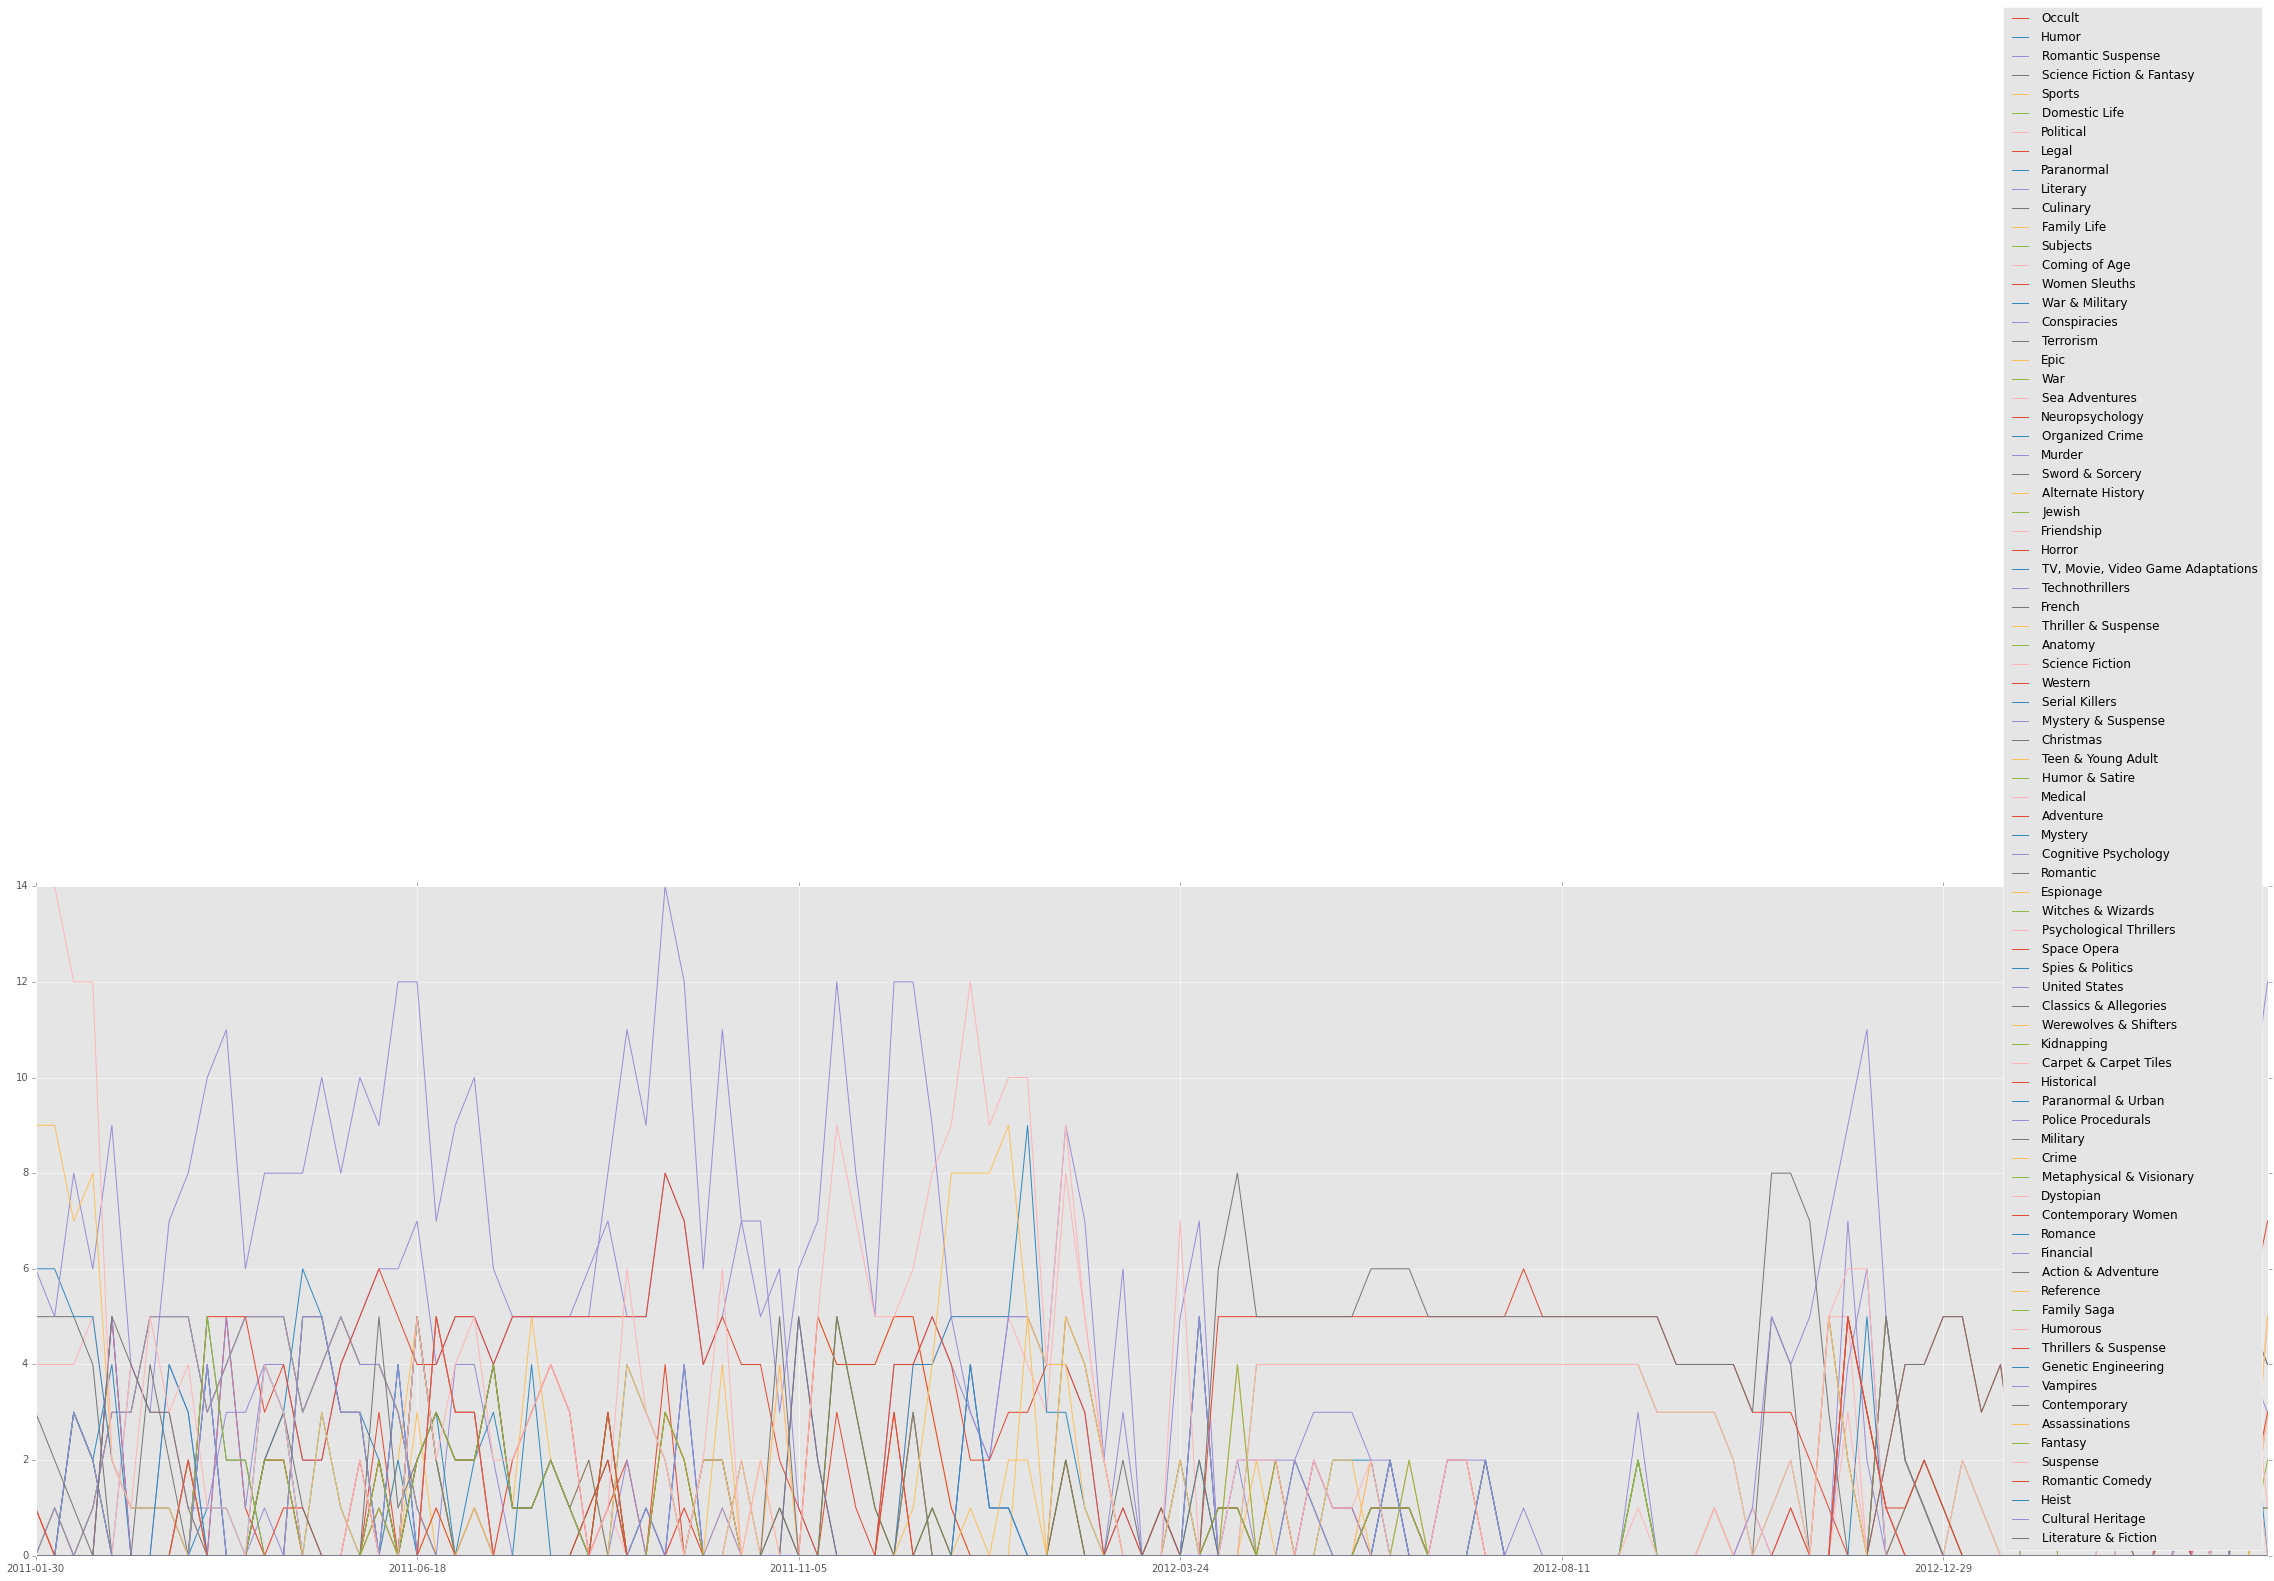

In [53]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

node_df = pd.DataFrame(data = np.transpose(x), index = sorted(all_dates), columns = member_freq_dict.keys())
node_df.plot( figsize=(40 ,12))

In [ ]:
high_node_df = pd.DataFrame(data = np.transpose(x), index = sorted(all_dates), columns = member_freq_dict.keys())
high_node_df.plot(figsize=(36,18))

In [33]:
node_df

Occult  Humor  Romantic Suspense  Science Fiction & Fantasy  \
2011-01-30       0      0                  0                          0   
2011-02-05       0      0                  0                          0   
2011-02-12       3      0                  0                          0   
2011-02-19       2      0                  0                          0   
2011-02-26       0      0                  5                          0   
2011-03-05       0      0                  0                          0   
2011-03-12       0      0                  0                          0   
2011-03-19       0      0                  0                          0   
2011-03-26       0      0                  0                          0   
2011-04-02       0      0                  0                          4   
2011-04-09       0      0                  0                          0   
2011-04-16       0      0                  0                          0   
2011-04-23       0      0                  1                          0   
2011-04-30       0      0                  0                          0   
2011-05-07       0      0                  0                          0   
2011-05-14       0      0                  0                          0   
2011-05-21       0      0                  0                          0   
2011-05-28       0      0                  0                          0   
2011-06-04       0      0                  0                          0   
2011-06-11       0      0                  0                          0   
2011-06-18       0      0                  0                          0   
2011-06-25       0      5                  0                          0   
2011-07-02       0      3                  0                          0   
2011-07-09       0      3                  0                          0   
2011-07-16       0      0                  0                          0   
2011-07-23       0      0                  0                          0   
2011-07-30       0      0                  0                          0   
2011-08-06       0      0                  0                          0   
2011-08-13       0      0                  0                          0   
2011-08-20       0      0                  0                          0   
...            ...    ...                ...                        ...   
2012-10-06       0      0                  0                          0   
2012-10-13       0      0                  0                          0   
2012-10-20       0      0                  0                          0   
2012-10-27       0      0                  0                          0   
2012-11-03       0      0                  0                          0   
2012-11-10       0      0                  0                          0   
2012-11-17       0      0                  0                          0   
2012-11-24       0      5                  0                          0   
2012-12-01       0      3                  0                          0   
2012-12-08       0      1                  0                          0   
2012-12-15       0      0                  0                          0   
2012-12-22       0      0                  0                          0   
2012-12-29       0      0                  0                          0   
2013-01-05       0      0                  0                          0   
2013-01-12       0      0                  0                          0   
2013-01-19       0      0                  0                          0   
2013-01-26       0      0                  0                          0   
2013-02-02       0      0                  0                          0   
2013-02-09       0      0                  0                          0   
2013-02-16       0      0                  0                          0   
2013-02-23       0      0                  0                          0   
2013-03-02       0      0            